<a href="https://colab.research.google.com/github/nischayggowda105/Facial-Recognition/blob/main/FER_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Facial Emotion Recognition**

**Import dependencies**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
# Distinct emotions.
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

As we can observe there are total **7 kinds of emotions** . Now we shall label each emotions for further study.

In [4]:
# Assigning label to Emotion values.
emotion_label_to_text = {0:'anger', 1:'disgust',2:'fear', 3:'happiness', 4:'sadness', 5:'suprise', 6:'neutral'}

In [5]:
# Count of emotions
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
# adding label to emotions
emotion_list = []
for i in range(len(df)):
     temp = emotion_label_to_text[df['emotion'][i]]
     emotion_list.append(temp)
df1 = df.copy()
df1['emotion_label'] = emotion_list
df1.head()

,emotion,pixels,Usage,emotion_label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,anger
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,anger
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,sadness
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


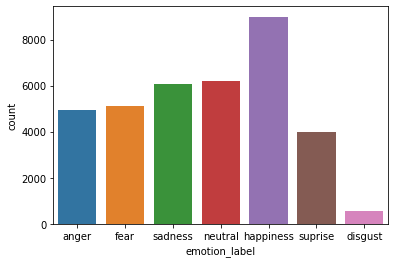

In [7]:
# Count plot
sns.countplot(df1.emotion_label)
plt.show()

Majority emotion classes belong to 'happiness', followed by 'neutral' and 'sadness'.

In [8]:
math.sqrt(len(df['pixels'][0].split(' ')))

48.0

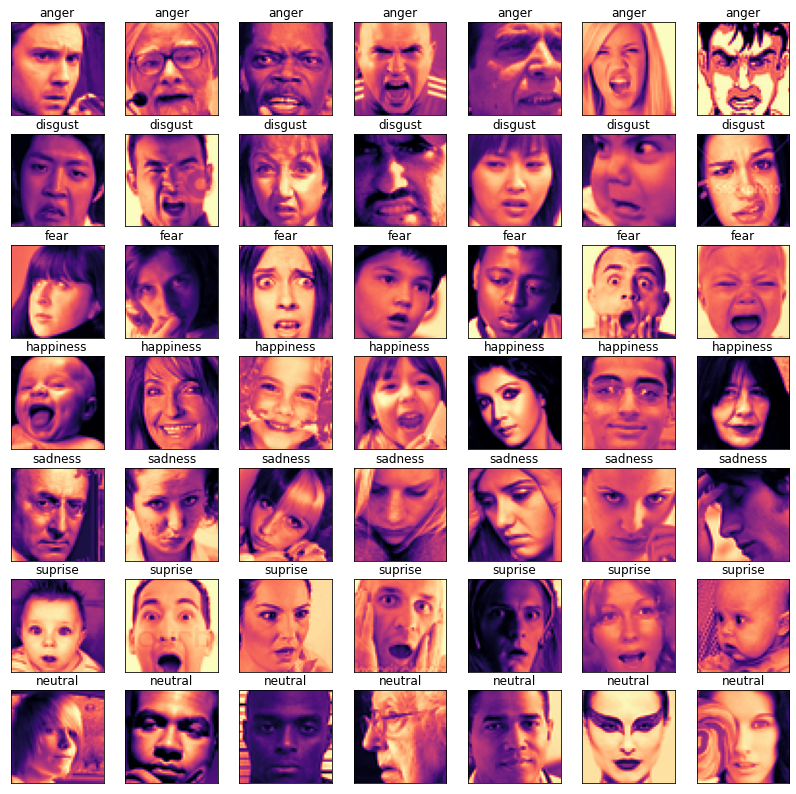

In [9]:
# Display images
fig = plt.figure(1, (14,14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1

        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='magma')   # colormap
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout

In [10]:
# Our intrested lebls are '3', '4', & '6'.
INTRESTED_LABEL = [3,4,6]
df = df[df.emotion.isin(INTRESTED_LABEL)]
df.shape

(21264, 3)

In [11]:
# Convert 2d to 3d pixel matrix.
img_array = df.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis= 0)
img_array.shape

(21264, 48, 48, 1)

In [12]:
# Label Encoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [13]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{3: 0, 4: 1, 6: 2}

## **`Train, Test and Validation.`**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [15]:
del df
del img_array
del img_labels

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [17]:
# Normalizing results, as neural networks are very sensitive to unormalized data.
X_train = X_train / 255
X_test = X_test /255

In [18]:
# Building a Deep CNN.
def build_network(optim):
    '''
    '''
    # Layer 1
    net = Sequential(name='D-CNN')
    net.add(
        Conv2D(
            filters = 64,
            kernel_size = (5,5),
            input_shape = (img_width, img_height, img_depth),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))

    # Layer 2
    net.add(
        Conv2D(
            filters = 64,
            kernel_size = (5,5),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    
    # Layer 3
    net.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))

    # Layer 4
    net.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    # Layer 5
    net.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))

    # Layer 6
    net.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal',
            name = 'conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(Flatten(name='flatten'))
    net.add(
        Dense(
            128,
            activation = 'relu',
            kernel_initializer = 'he_normal',
            name = 'dense_1'
        )
    )   
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation = 'softmax',
            name = 'out_layer'
        )
    )

    net.compile(
        loss = 'categorical_crossentropy',
        optimizer = optim,
        metrics = ['accuracy']
    )

    net.summary()

    return net

In [19]:
'''
To avoid Overfitting, we use 'early stopping'.
'''

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [
    early_stopping,
    lr_scheduler
]

In [20]:
# As data is less, so we use ImageDataGenerator.
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)
train_datagen.fit(X_train)

In [21]:
batch_size = 32
epochs = 10
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001)
]

model = build_network(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True
)

# # load saved D-CNN model.
# model = tf.keras.models.load_model('DCNN_model.h5')
# history = model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     validation_data = (X_test, y_test),
#     steps_per_epoch = len(X_train) / batch_size,
#     epochs = epochs,
#     callbacks = callbacks,
#     use_multiprocessing = True
# )

Model: "D-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxool2d_1 (MaxPooling2D)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856 

In [22]:
model_yaml = model.to_yaml()
with open('model.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)

model.save('DCNN_model.h5')

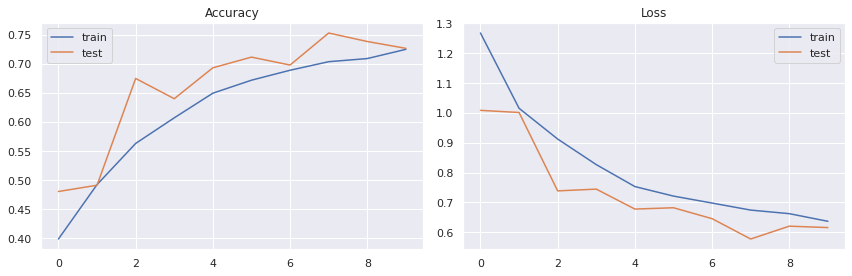

In [23]:
sns.set()
fig = plt.figure(0, (12,4))

# accuracy plot
ax = plt.subplot(1,2,1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.tight_layout()

# loss plot
ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='test')
plt.title('Loss')
plt.tight_layout()

plt.show()

Epochs history shows that accuracy grdually increases, we can improve it by given more number of epochs. Make sure not to set very high epoch value, it may overfit training data.

## **Accuracy**

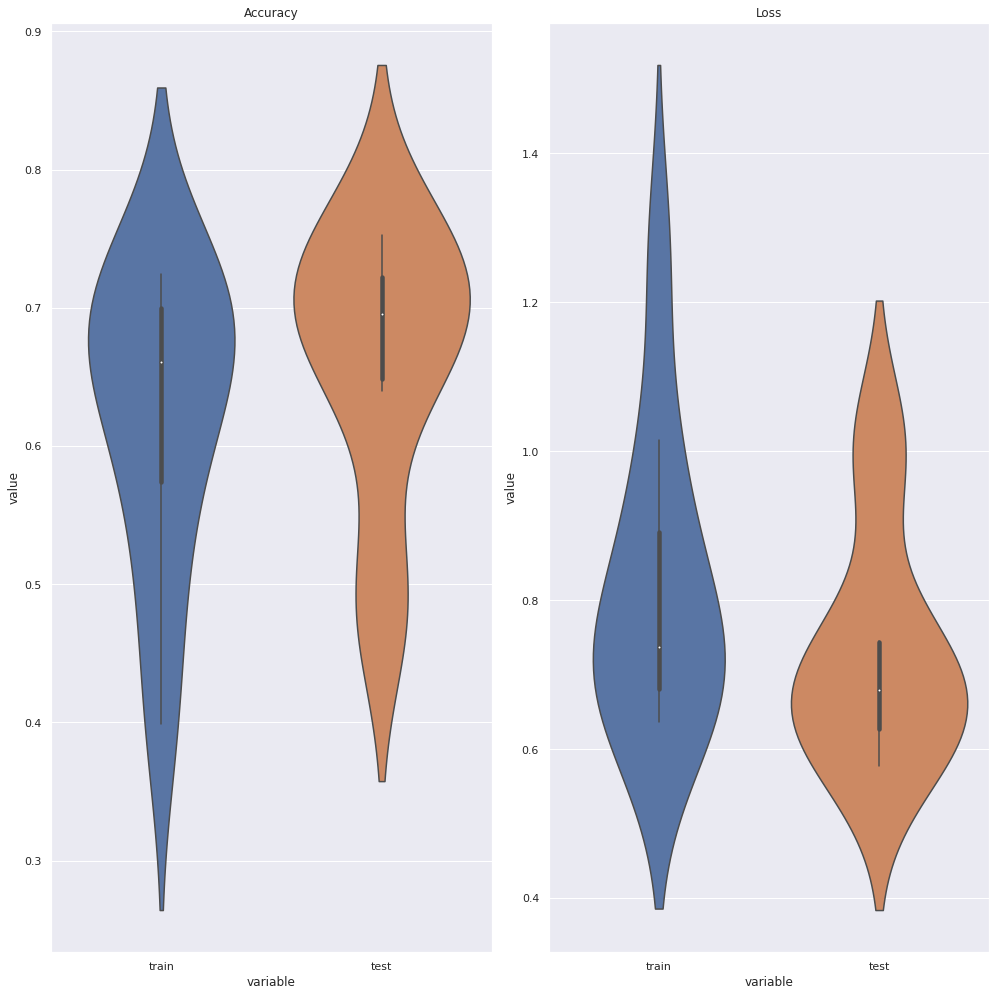

In [24]:
df_accuracy = pd.DataFrame({'train': history.history['accuracy'], 
                            'test':history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 
                        'test': history.history['val_loss']})

fig = plt.figure(0, (14,14))
ax = plt.subplot(1,2,1)
sns.violinplot(x='variable', y='value', data=pd.melt(df_accuracy), 
               showfliers=False)
# sns.violinplot(x='variable', y='value', data=pd.melt(df_accu))
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1,2,2)
sns.violinplot(x='variable', y='value', data=pd.melt(df_loss), showflier=False)
plt.title('Loss')
plt.tight_layout()

plt.show()

In [25]:
yhat_test = model.predict_classes(X_test)
# plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))
# plt.show()
print(f'Total Wrong Predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)} \n')
print(classification_report(np.argmax(y_test, axis=1), yhat_test))

Total Wrong Predictions: 582 

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       899
           1       0.64      0.59      0.61       608
           2       0.60      0.64      0.62       620

    accuracy                           0.73      2127
   macro avg       0.70      0.70      0.70      2127
weighted avg       0.73      0.73      0.73      2127



In [28]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

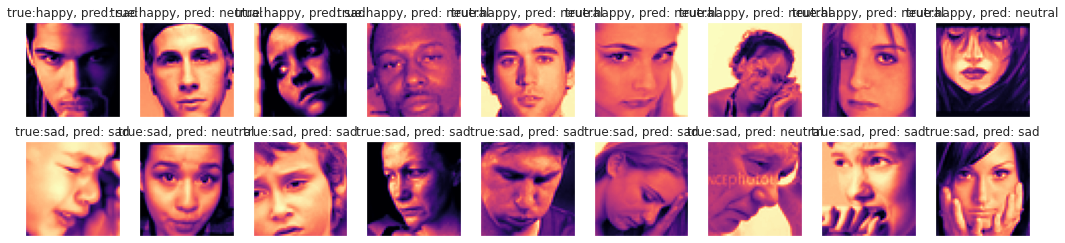

In [32]:
# Evaluate our model by giving images input.
np.random.seed(2)
random_happy_imgs = np.random.choice(np.where(y_test[:,0]==0)[0], size=9)
random_sad_imgs = np.random.choice(np.where(y_test[:,1]==1)[0], size=9)

fig = plt.figure(1, (18,4))
for i, (happyidx, sadidx) in enumerate(zip(random_happy_imgs, random_sad_imgs)):
  # first row
  ax = plt.subplot(2, 9, i+1)
  sample_img = X_test[happyidx, :, :, 0]
  ax.imshow(sample_img, cmap='magma')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'true:happy, pred: {mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}')

  # Second row.
  ax = plt.subplot(2, 9, i+10)
  sample_img = X_test[sadidx, :, :, 0]
  ax.imshow(sample_img, cmap='magma')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'true:sad, pred: {mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}')

  plt.tight_layout